# <center>TP10 - VAE </center>

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline
import math
import numpy as np
import pandas as pd

import torch
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
from torch import optim
import copy

from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class DataMNIST(Dataset):
    def __init__(self,data):
        self.x = data.data.to(device)
        self.y = data.targets
    def __getitem__(self,index):
        x = (self.x[index].to(torch.float) / self.x.max()).reshape(-1)
        y = self.y[index]
        
        return x,y
    def __len__(self):
        return len(self.x)

In [3]:
class VAE(nn.Module):
    
    def __init__(self,i_d,d_latent):
        super(VAE, self).__init__()
        
        #encoder
        self.f1 = nn.Linear(i_d,100)
        self.f2_1 = nn.Linear(100,d_latent)
        self.f2_2 = nn.Linear(100,d_latent)
        
        #decoder
        self.f3 = nn.Linear(d_latent,100)
        self.f4 = nn.Linear(100,i_d)
        
    def encode(self,x):
        x = torch.relu(self.f1(x))
        return self.f2_1(x),self.f2_2(x)
        
    def sample_latent(self,mu,logvar):
        return mu + torch.exp( 0.5 * logvar ) * torch.randn_like(logvar).to(device)
    
    def decode(self,z):
        z = torch.relu(self.f3(z))
        return torch.sigmoid(self.f4(z))
        
    
    def forward(self,x):
        
        #Encoding using x to get mu,sigma
        mu,logvar = self.encode(x)
        
        #Sampling the latent vector under N(mu,sigma) using reparametrization trick
        z = self.sample_latent(mu,logvar)
        
        #Decoding using z to get the bernoulli parameterss
        z = self.decode(z)
        
        return z,mu,logvar

In [4]:
#paramètres
d_in = 784 #input dim

learning_rate = 0.01
batch = 60000
epochs = 1000
d_latent = 2
a = 2 #BCE coefficient
b = 1 #KL coefficient

#instanciation des modèles
model = VAE(d_in,d_latent).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Chargement des données
mnist_trainset = datasets.MNIST(root='data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='data', train=False, download=True, transform=None)
train_loader = torch.utils.data.DataLoader(DataMNIST(mnist_trainset), batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(DataMNIST(mnist_testset), batch_size=batch, shuffle=True)

In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function( z , x , mu, logvar ):
    BCE = F.binary_cross_entropy( z , x , reduction='sum') / z.shape[0]

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp()) / z.shape[0]

    return BCE,KLD

In [ ]:
learning_rate = 0.0001
#Apprentissage du modèle
n = train_loader.dataset.__len__() # training size
#!rm -r runs
writer = SummaryWriter("runs/linear_latent=2")


for i in range(362,epochs):
    total_loss = total_BCE = total_KLD = 0
    
    for x,_ in  train_loader:
        optimizer.zero_grad()

        z,mu,logvar = model.forward(x)
        BCE,KLD = loss_function( z , x , mu, logvar )
        loss = a * BCE + b * KLD
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_BCE += BCE.item()
        total_KLD += KLD.item()
        
    # Visualisation et envoi sur tensorboard
    print(i,"\t",round(total_loss * batch / n ,0))
    writer.add_scalar('Loss',total_loss * batch / n    ,i)
    writer.add_scalar('Loss_BCE',total_BCE * batch / n    ,i)
    writer.add_scalar('Loss_KLD',total_KLD * batch / n    ,i)
    writer.add_image('original', x[0].reshape(1,28,28) ,i)
    writer.add_image('generated', z[0].reshape(1,28,28),i)

writer.close()

362 	 312.0
363 	 313.0
364 	 313.0
365 	 312.0
366 	 312.0
367 	 313.0
368 	 313.0
369 	 312.0
370 	 312.0


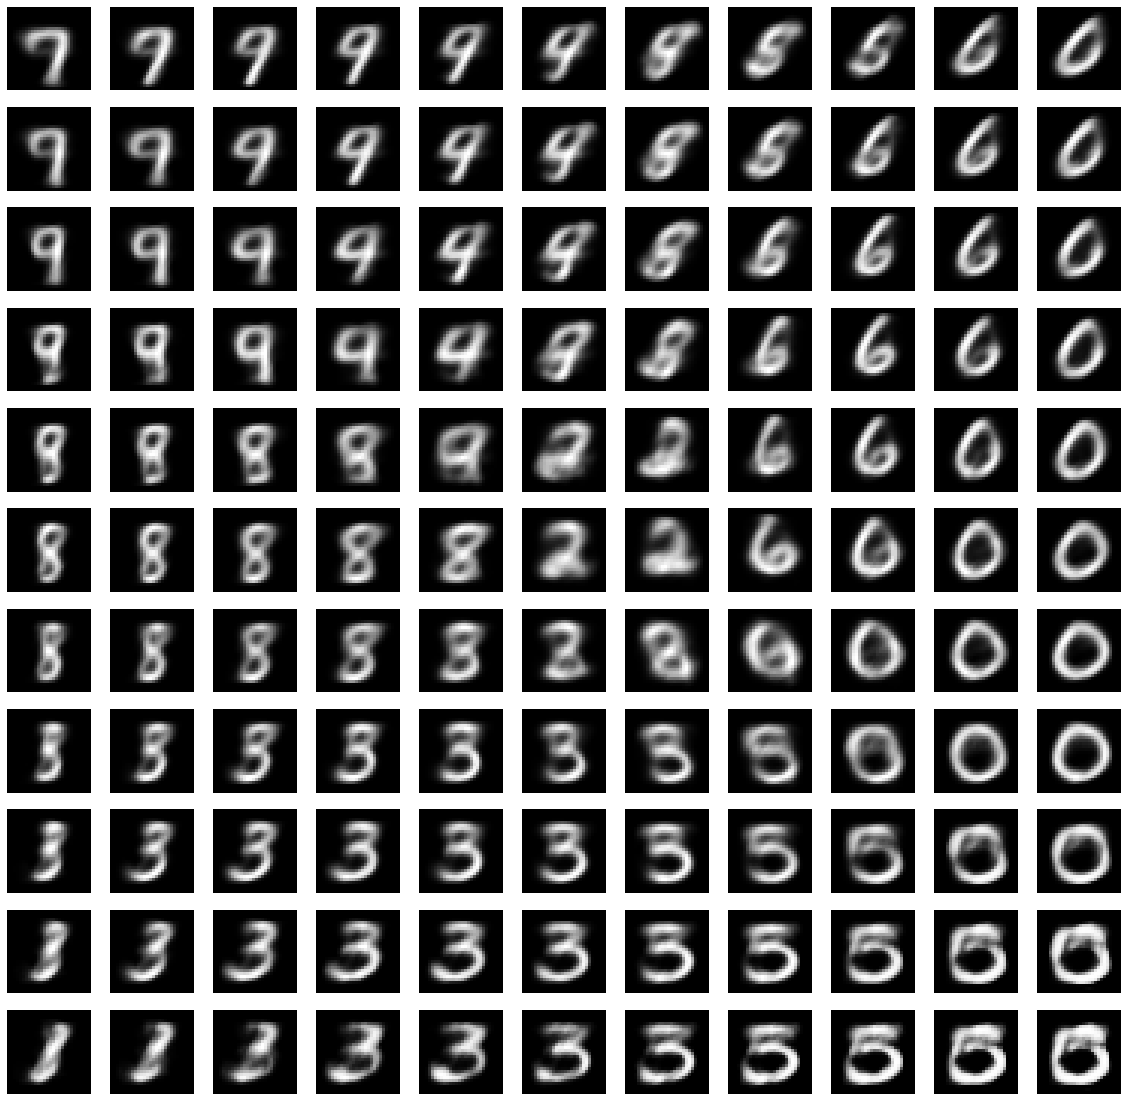

In [44]:
fig = plt.figure(figsize=(20,20))

with torch.no_grad():   
    #samples = torch.stack([torch.randn(1).to(device)*10 for _ in range(25)],dim=0)
    #samples = torch.Tensor(np.linspace(-5,5, num=100)).unsqueeze(1).to(device)
    samples = torch.Tensor((np.array([[(x,y) for x in range(11)] for y in range(11)])-5)/3).reshape(-1,2).to(device)
    imgs = model.decode(samples).cpu().numpy().reshape(-1,28,28)
    
for i,img in enumerate(imgs):
    fig.add_subplot(11,11,i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.savefig("TME10-numb_lin_2")

In [14]:
import numpy as np

array([-2.        , -1.83333333, -1.66666667, -1.5       , -1.33333333,
       -1.16666667, -1.        , -0.83333333, -0.66666667, -0.5       ,
       -0.33333333, -0.16666667,  0.        ,  0.16666667,  0.33333333,
        0.5       ,  0.66666667,  0.83333333,  1.        ,  1.16666667,
        1.33333333,  1.5       ,  1.66666667,  1.83333333,  2.        ])

In [21]:
samples = torch.stack([torch.randn(1).to(device)*10 for _ in range(25)],dim=0)

In [26]:
samples.shape

torch.Size([25, 1])

In [25]:
samples = 

In [34]:
torch.Tensor(np.linspace(-5,5, num=100)).unsqueeze(1).to(device).shape

torch.Size([100, 1])

tensor([[-1.0000, -1.0000],
        [-0.8000, -1.0000],
        [-0.6000, -1.0000],
        [-0.4000, -1.0000],
        [-0.2000, -1.0000],
        [ 0.0000, -1.0000],
        [ 0.2000, -1.0000],
        [ 0.4000, -1.0000],
        [ 0.6000, -1.0000],
        [ 0.8000, -1.0000],
        [ 1.0000, -1.0000],
        [-1.0000, -0.8000],
        [-0.8000, -0.8000],
        [-0.6000, -0.8000],
        [-0.4000, -0.8000],
        [-0.2000, -0.8000],
        [ 0.0000, -0.8000],
        [ 0.2000, -0.8000],
        [ 0.4000, -0.8000],
        [ 0.6000, -0.8000],
        [ 0.8000, -0.8000],
        [ 1.0000, -0.8000],
        [-1.0000, -0.6000],
        [-0.8000, -0.6000],
        [-0.6000, -0.6000],
        [-0.4000, -0.6000],
        [-0.2000, -0.6000],
        [ 0.0000, -0.6000],
        [ 0.2000, -0.6000],
        [ 0.4000, -0.6000],
        [ 0.6000, -0.6000],
        [ 0.8000, -0.6000],
        [ 1.0000, -0.6000],
        [-1.0000, -0.4000],
        [-0.8000, -0.4000],
        [-0.6000, -0